# Predicting NBA statistics for a player in a game

# The Data
The dataset is from the 2023-24 NBA season. It contains every gamelog of every player.

In [1]:
import pandas as pd
import numpy as np
from datetime import timedelta

df = pd.read_csv('nba-player-gamelogs.csv')
df['date'] = pd.to_datetime(df['date'])
df

,season,date,playerTeamId,opposingTeamId,playerId,position,isStarter,minutes,points,assists,...,blocks,turnovers,fieldGoalsAttempted,fieldGoalsMade,freeThrowsAttempted,freeThrowsMade,fouls,threesAttempted,threesMade,gamescore
0,2022,2023-03-27,1610612765,1610612749,1630587,SF,1,34.500000,9,2,...,0,0,5,4,0,0,2,1.0,1.0,9.9
1,2022,2023-03-27,1610612765,1610612749,1628963,PF,1,35.733333,16,2,...,0,0,11,6,4,3,0,2.0,1.0,16.2
2,2022,2023-03-27,1610612765,1610612749,1630164,C,1,20.333333,14,1,...,0,1,12,5,4,4,1,1.0,0.0,10.9
3,2022,2023-03-27,1610612765,1610612749,1631093,PG,1,31.683333,32,8,...,0,4,19,9,12,11,4,6.0,3.0,24.7
4,2022,2023-03-27,1610612765,1610612749,1630165,PG,1,37.300000,14,5,...,0,0,17,6,5,2,4,3.0,0.0,8.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63012,2023,2024-03-19,1610612757,1610612741,1641871,C,0,16.950000,14,0,...,0,0,6,5,2,2,3,3.0,2.0,11.3
63013,2023,2024-03-19,1610612757,1610612741,1641712,PG,0,3.683333,0,0,...,0,0,2,0,0,0,0,1.0,0.0,-1.1
63014,2023,2024-03-19,1610612757,1610612741,1630641,C,0,0.000000,0,0,...,0,0,0,0,0,0,0,0.0,0.0,0.0
63015,2023,2024-03-19,1610612757,1610612741,1629650,C,0,0.000000,0,0,...,0,0,0,0,0,0,0,0.0,0.0,0.0


# Feature Engineering
To predict the statistic a player will get in an upcoming game, I will consider the player's 
average, the opposing defense's strength.

In [2]:
def calculate_average_stats(row):
    """
    Gets the player's average for each relevant statistic, adjusted for recency of games
    and the player's current place on the team. If the player is typically a bench player
    but is starting the game, their expected total should be higher.
    """
    
    # Gets all the games previously played by the player
    prev_gms = df[(df['date'] < row['date']) & (df['playerId'] == row['playerId'])]

    # The stats whose weighted averages will be taken.
    stats = {'fieldGoalsAttempted': None, 'fieldGoalsMade': None, 
             'threesMade': None, 'freeThrowsAttempted': None, 'freeThrowsMade': None,
             'points': None, 'steals': None, 'blocks': None,
            'assists': None, 'reboundsTotal': None, 'reboundsOffensive': None,
             'reboundsDefensive': None, 'turnovers': None, 'fouls': None}
        
    for stat in stats.keys():
        if len(prev_gms) == 0 and row['isStarter']==1:
            # If the player is a starter and has no games previously played,
            # they will be expected to get the amount of the stats typical
            # of a starter that plays their position. This is typical for rookies.
            stats[stat] = df[(df['date'] < row['date']) & (df['isStarter']==1) 
          q                   & (df['position']==row['position'])][stat].mean()
            
        elif len(prev_gms) == 0 and row['isStarter']==0:
            # If a player has no games previously played, they will be expected to accumulate
            # stats typical for a bench player that plays the player's position.
            stats[stat] = df[(df['date'] < row['date']) & (df['isStarter']==0) 
                             & (df['position']==row['position'])][stat].mean()
            
        elif prev_gms.tail(5)['isStarter'].sum() < 3 and row['isStarter']==1:
            # If the player has not started in at least 3 of the past 5 games and is starting in the upcoming
            # game, they should be expected to acquire stats they averaged as a starter. 
            player_start_games = df[(df['date'] < row['date']) & (df['isStarter']==1)
                                    & (df['playerId']==row['playerId'])]
            if len(player_start_games) < 3:
                # If the sample size with them as a starter is less than 3, use the average of the
                # players that start and play the player's position.
                stats[stat] = df[(df['date'] < row['date']) & (df['isStarter']==1) 
                                 & (df['position']==row['position'])][stat].mean()
            else:
                # If the sample size of them as a starter is more than 2, use the average they got
                # as a starter.
                stats[stat] = player_start_games[stat].mean()
        elif prev_gms.tail(5)['isStarter'].sum() > 2 and row['isStarter']==0:
            # If the player has started at least 3 times in the past 5 games and is 
            # starting in the upcoming game, they should be expected to acquire stats they averaged 
            # as a bench player. 
            player_bench_games = df[(df['date'] < row['date']) & (df['isStarter']==0) 
                                    & (df['playerId']==row['playerId'])]
            if len(player_bench_games) < 3:
                # If the sample size with them as a bench player is less than 3, use the average of the
                # bench players that play the player's position.
                stats[stat] = df[(df['date'] < row['date']) & (df['isStarter']==0) 
                                 & (df['position']==row['position'])][stat].mean()
            else:
                # If the sample size of them as a starter is more than 2, use the average they got
                # as a bench player.
                stats[stat] = player_bench_games[stat].mean()
        else:
            # Get a weighted average where the weights are the days since each game in the average was
            # played, weighted with an exponential decay rate of 0.98.
            weights = .98 ** ((pd.to_datetime(row['date']) - pd.to_datetime(prev_gms['date'])).dt.days)
            weighted_sum = np.sum(weights * prev_gms[stat])
            weights_sum = np.sum(weights)
            if weights_sum > 0:
                weighted_avg = weighted_sum / weights_sum
                stats[stat] = weighted_avg
    
    return pd.Series(stats)
    
df[['avgFieldGoalsAttempted', 'avgFieldGoalsMade', 'avgThreesMade',
    'avgFreeThrowsAttempted', 'avgFreeThrowsMade', 'avgPoints', 'avgSteals', 'avgBlocks',
   'avgAssists', 'avgReboundsTotal', 'avgReboundsOffensive', 'avgReboundsDefensive', 
    'avgTurnovers', 'avgFouls']
  ] = df.apply(calculate_average_stats, axis=1)
df

,season,date,playerTeamId,opposingTeamId,playerId,position,isStarter,minutes,points,assists,...,avgFreeThrowsMade,avgPoints,avgSteals,avgBlocks,avgAssists,avgReboundsTotal,avgReboundsOffensive,avgReboundsDefensive,avgTurnovers,avgFouls
0,2022,2023-03-27,1610612765,1610612749,1630587,SF,1,34.500000,9,2,...,0.529412,8.294118,0.705882,0.588235,1.117647,2.705882,0.470588,2.235294,0.470588,1.529412
1,2022,2023-03-27,1610612765,1610612749,1628963,PF,1,35.733333,16,2,...,1.857143,12.904762,0.761905,0.666667,0.952381,6.571429,2.380952,4.190476,1.380952,2.380952
2,2022,2023-03-27,1610612765,1610612749,1630164,C,1,20.333333,14,1,...,1.500000,13.857143,0.214286,1.000000,0.714286,8.857143,2.571429,6.285714,1.785714,3.071429
3,2022,2023-03-27,1610612765,1610612749,1631093,PG,1,31.683333,32,8,...,3.694627,15.719518,0.631021,0.260595,5.771888,3.574194,0.987934,2.586260,3.499809,3.304775
4,2022,2023-03-27,1610612765,1610612749,1630165,PG,1,37.300000,14,5,...,1.283187,10.536728,1.685154,0.351343,7.089899,2.819456,0.267817,2.551639,2.775505,2.690147
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63012,2023,2024-03-19,1610612757,1610612741,1641871,C,0,16.950000,14,0,...,0.894737,6.657895,0.342105,0.368421,0.763158,2.526316,1.157895,1.368421,0.631579,1.973684
63013,2023,2024-03-19,1610612757,1610612741,1641712,PG,0,3.683333,0,0,...,0.263050,1.794071,0.130805,0.000000,0.629757,1.085296,0.390068,0.695228,0.418602,0.720541
63014,2023,2024-03-19,1610612757,1610612741,1630641,C,0,0.000000,0,0,...,0.116444,0.624010,0.035686,0.395541,0.309962,0.881695,0.334360,0.547335,0.316716,0.898530
63015,2023,2024-03-19,1610612757,1610612741,1629650,C,0,0.000000,0,0,...,0.059722,1.172024,0.023178,0.102575,0.149998,1.236230,0.502427,0.733803,0.185446,0.487610


In [3]:
def calculate_opp_stat_rating(row):
    """
    Calculates the opponent's strength of each statistic they allow per minute against the
    player's position and starting status.
    """
    
    # The defensive rating's will be calculated for these stats
    stats = {'fieldGoalsAttempted': None, 'fieldGoalsMade': None, 
             'threesMade': None, 'freeThrowsAttempted': None, 'freeThrowsMade': None,
             'points': None, 'steals': None, 'blocks': None,
            'assists': None, 'reboundsTotal': None, 'reboundsOffensive': None,
             'reboundsDefensive': None, 'turnovers': None, 'fouls': None}
    
    # All games the opposing team has played over the previous 30 days.
    opp_gms = df[(df['date'] < row['date']) & (df['date'] > (row['date'] - timedelta(days=30))) 
                 & (df['opposingTeamId'] == row['opposingTeamId'])]
    
    for stat in stats.keys():
        # If the opponent has not played 15 games yet in the season, use all their games
        # from last season and the current season to estimate the opponent's rating
        if len(opp_gms['date'].unique()) < 15:
            opp_gms = df[(df['date'] < row['date']) & (df['opposingTeamId'] == row['opposingTeamId'])]
        
        if row['isStarter']==1:
            # If the player is a starter, evaluate the defense's effectivness against starters
            opp_gms = opp_gms[opp_gms['isStarter']==1]
        else:
            # If the player is a bench player, evaluate the defense's strength against bench players
            opp_gms = opp_gms[opp_gms['isStarter']==0]
            
        # Get the total number of the stat accumulated by players with the given position against 
        # this team and divide by the total minutes played by those players
        opp_fga_rating = (opp_gms[opp_gms['position']==row['position']][stat].sum() 
                          / opp_gms[opp_gms['position']==row['position']]['minutes'].sum())
        stats[stat] = opp_fga_rating
    return pd.Series(stats)
    
df[['oppDRatingFieldGoalsAttempted', 'oppDRatingFieldGoalsMade', 
    'oppDRatingThreesMade', 'oppDRatingFreeThrowsAttempted', 'oppDRatingFreeThrowsMade',
   'oppDRatingPoints', 'oppDRatingSteals', 'oppDRatingBlocks', 'oppDRatingAssists', 
    'oppDRatingReboundsTotal', 'oppDRatingReboundsOffensive', 'oppDRatingReboundsDefensive',
    'oppDRatingTurnovers', 'oppDRatingFouls']] = df.apply(calculate_opp_stat_rating, axis=1)
df

C:\Users\sfedd\AppData\Local\Temp\ipykernel_12068\4051672303.py:27: RuntimeWarning: invalid value encountered in scalar divide
  opp_fga_rating = (opp_gms[opp_gms['position']==row['position']][stat].sum()


,season,date,playerTeamId,opposingTeamId,playerId,position,isStarter,minutes,points,assists,...,oppDRatingFreeThrowsMade,oppDRatingPoints,oppDRatingSteals,oppDRatingBlocks,oppDRatingAssists,oppDRatingReboundsTotal,oppDRatingReboundsOffensive,oppDRatingReboundsDefensive,oppDRatingTurnovers,oppDRatingFouls
0,2022,2023-03-27,1610612765,1610612749,1630587,SF,1,34.500000,9,2,...,0.076320,0.524062,0.027984,0.007632,0.068688,0.160271,0.050880,0.109392,0.043248,0.045792
1,2022,2023-03-27,1610612765,1610612749,1628963,PF,1,35.733333,16,2,...,0.052246,0.370473,0.030873,0.011874,0.123491,0.237483,0.049871,0.187611,0.059371,0.080744
2,2022,2023-03-27,1610612765,1610612749,1630164,C,1,20.333333,14,1,...,0.084402,0.576343,0.033761,0.033761,0.115751,0.301435,0.091636,0.209799,0.048230,0.108517
3,2022,2023-03-27,1610612765,1610612749,1631093,PG,1,31.683333,32,8,...,0.063431,0.582964,0.033226,0.009062,0.172171,0.129883,0.021144,0.108739,0.078534,0.066452
4,2022,2023-03-27,1610612765,1610612749,1630165,PG,1,37.300000,14,5,...,0.063431,0.582964,0.033226,0.009062,0.172171,0.129883,0.021144,0.108739,0.078534,0.066452
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63012,2023,2024-03-19,1610612757,1610612741,1641871,C,0,16.950000,14,0,...,0.055432,0.412966,0.026330,0.051274,0.063746,0.269537,0.099777,0.169760,0.053353,0.142737
63013,2023,2024-03-19,1610612757,1610612741,1641712,PG,0,3.683333,0,0,...,0.049298,0.383752,0.032543,0.011277,0.126951,0.120829,0.024488,0.096341,0.055420,0.071531
63014,2023,2024-03-19,1610612757,1610612741,1630641,C,0,0.000000,0,0,...,0.055432,0.412966,0.026330,0.051274,0.063746,0.269537,0.099777,0.169760,0.053353,0.142737
63015,2023,2024-03-19,1610612757,1610612741,1629650,C,0,0.000000,0,0,...,0.055432,0.412966,0.026330,0.051274,0.063746,0.269537,0.099777,0.169760,0.053353,0.142737


# Visualize the Data

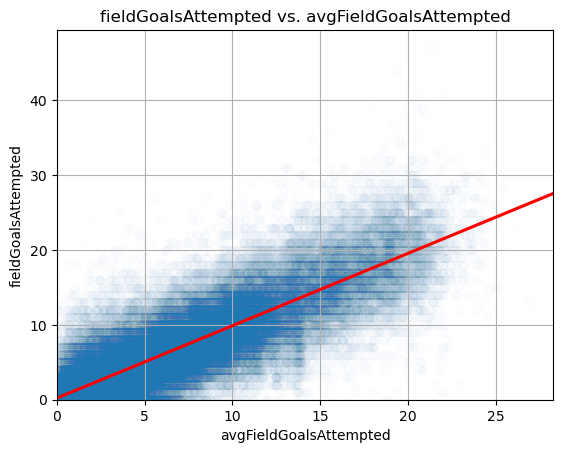

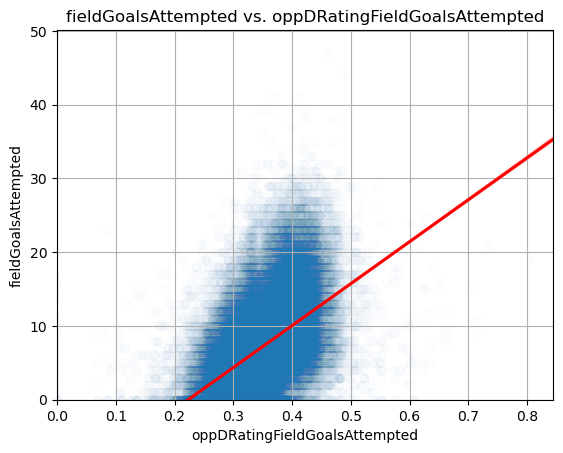

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

attributes = ['avgFieldGoalsAttempted', 'oppDRatingFieldGoalsAttempted']

df_current_season = df[df['season'] == max(df['season'].unique())]

for attribute in attributes:
    sns.regplot(data=df, x=attribute, y='fieldGoalsAttempted', scatter_kws={'alpha':0.01}, line_kws={'color':'red'}, truncate=False)
    plt.title(f'fieldGoalsAttempted vs. {attribute}')
    plt.xlabel(attribute)
    plt.ylabel('fieldGoalsAttempted')
    plt.grid(True)
    plt.xlim(left=0)
    plt.ylim(bottom=0)
    plt.show()

# Train the model

In [4]:
# Get the dataset for machine learning
ml_df = df[df['season'] == max(df['season'].unique())].dropna().copy()[[
        'date', 'playerId', 'fieldGoalsAttempted', 'fieldGoalsMade', 'threesMade', 
    'points', 'steals', 'blocks', 'assists', 'reboundsTotal', 'reboundsOffensive',
    'reboundsDefensive', 'turnovers', 'freeThrowsAttempted', 'freeThrowsMade', 'fouls', 'gamescore',
       'avgFieldGoalsAttempted', 'avgFieldGoalsMade', 'avgThreesMade', 
    'avgPoints', 'avgSteals', 'avgBlocks', 'avgFouls', 'avgReboundsOffensive', 'avgReboundsDefensive',
       'avgAssists', 'avgReboundsTotal', 'avgTurnovers', 'avgFreeThrowsAttempted', 'avgFreeThrowsMade',
    'oppDRatingFieldGoalsAttempted', 'oppDRatingFieldGoalsMade', 
    'oppDRatingThreesMade', 'oppDRatingFreeThrowsAttempted', 'oppDRatingFreeThrowsMade',
   'oppDRatingPoints', 'oppDRatingSteals', 'oppDRatingBlocks', 'oppDRatingAssists', 
    'oppDRatingReboundsTotal', 'oppDRatingReboundsOffensive', 'oppDRatingReboundsDefensive',
    'oppDRatingTurnovers', 'oppDRatingFouls'
]]

ml_df

,date,playerId,fieldGoalsAttempted,fieldGoalsMade,threesMade,points,steals,blocks,assists,reboundsTotal,...,oppDRatingFreeThrowsMade,oppDRatingPoints,oppDRatingSteals,oppDRatingBlocks,oppDRatingAssists,oppDRatingReboundsTotal,oppDRatingReboundsOffensive,oppDRatingReboundsDefensive,oppDRatingTurnovers,oppDRatingFouls
25,2024-02-10,1629060,13,9,2.0,21,0,1,1,5,...,0.081459,0.483371,0.023408,0.022706,0.091993,0.210904,0.047752,0.163152,0.051497,0.088013
26,2024-02-10,2544,13,6,2.0,21,1,1,14,4,...,0.081459,0.483371,0.023408,0.022706,0.091993,0.210904,0.047752,0.163152,0.051497,0.088013
27,2024-02-10,203076,11,7,0.0,20,1,1,6,6,...,0.081459,0.483371,0.023408,0.022706,0.091993,0.210904,0.047752,0.163152,0.051497,0.088013
28,2024-02-10,1630559,15,10,3.0,27,0,0,4,2,...,0.080486,0.514426,0.029705,0.012043,0.111998,0.110793,0.019469,0.091324,0.059411,0.066436
29,2024-02-10,1626156,19,9,6.0,30,1,0,5,2,...,0.102760,0.562305,0.034023,0.009196,0.180922,0.133335,0.024828,0.108507,0.077472,0.062529
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63012,2024-03-19,1641871,6,5,2.0,14,0,0,0,1,...,0.055432,0.412966,0.026330,0.051274,0.063746,0.269537,0.099777,0.169760,0.053353,0.142737
63013,2024-03-19,1641712,2,0,0.0,0,0,0,0,1,...,0.049298,0.383752,0.032543,0.011277,0.126951,0.120829,0.024488,0.096341,0.055420,0.071531
63014,2024-03-19,1630641,0,0,0.0,0,0,0,0,0,...,0.055432,0.412966,0.026330,0.051274,0.063746,0.269537,0.099777,0.169760,0.053353,0.142737
63015,2024-03-19,1629650,0,0,0.0,0,0,0,0,0,...,0.055432,0.412966,0.026330,0.051274,0.063746,0.269537,0.099777,0.169760,0.053353,0.142737


I will train the model to predict gamescore so that it can be compared to other models developed
by other researchers.
(https://captaincalculator.com/sports/basketball/game-score-calculator)

In [16]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

features = [
       'avgFieldGoalsAttempted', 'avgFieldGoalsMade', 
    'avgPoints', 'avgSteals', 'avgBlocks', 'avgFouls', 'avgReboundsOffensive', 'avgReboundsDefensive',
       'avgAssists', 'avgTurnovers', 'avgFreeThrowsAttempted', 'avgFreeThrowsMade',
    'oppDRatingFieldGoalsAttempted', 'oppDRatingFieldGoalsMade', 
    'oppDRatingFreeThrowsAttempted', 'oppDRatingFreeThrowsMade',
   'oppDRatingPoints', 'oppDRatingSteals', 'oppDRatingBlocks', 'oppDRatingAssists', 
    'oppDRatingReboundsOffensive', 'oppDRatingReboundsDefensive', 'oppDRatingTurnovers', 
    'oppDRatingFouls'
]
targets = ['gamescore']

X = ml_df[features].values
y = ml_df[targets].values

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Build the neural network model
model = Sequential([
    Dense(16, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(len(targets))  # Output layer with the number of target variables
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train_scaled, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=0)

# Evaluate the model
loss = model.evaluate(X_test_scaled, y_test, verbose=0)
print("Test Loss:", loss)

# Predict on test data
y_pred = model.predict(X_test_scaled)

# Calculate mean squared error
mse = mean_squared_error(y_test, y_pred)

# Calculate root mean squared error
rmse = np.sqrt(mse)

print("Root Mean Squared Error:", rmse)

C:\Users\sfedd\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Test Loss: 29.9725399017334
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Root Mean Squared Error: 5.479182145563914


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


C:\Users\sfedd\AppData\Local\Temp\ipykernel_12068\3335238872.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  example_player_df['predictedGamescore'] = model.predict(scaler.transform(example_player_df[features].values))


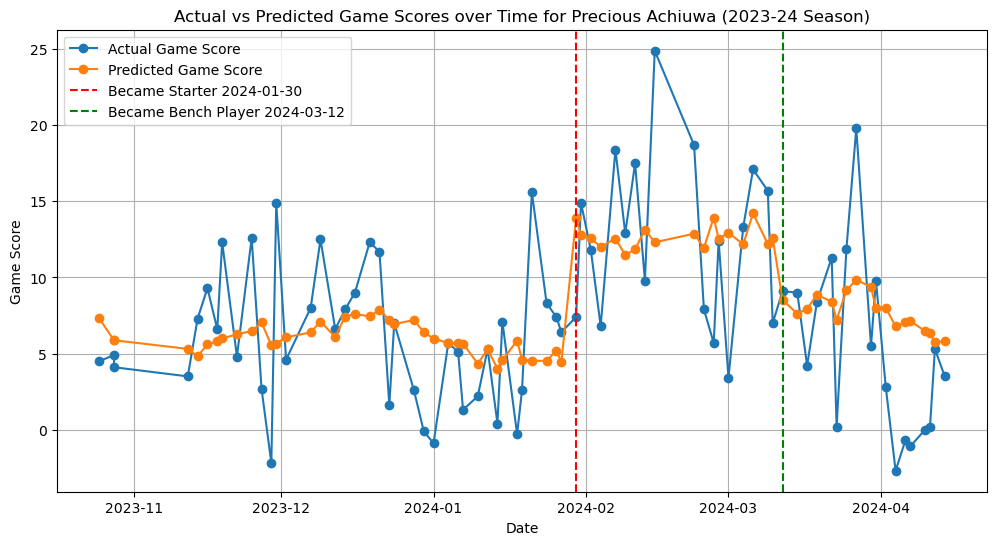

In [18]:
example_player_df = df[df['playerId'] == 1630173]
features = [
       'avgFieldGoalsAttempted', 'avgFieldGoalsMade', 
    'avgPoints', 'avgSteals', 'avgBlocks', 'avgFouls', 'avgReboundsOffensive', 'avgReboundsDefensive',
       'avgAssists', 'avgTurnovers', 'avgFreeThrowsAttempted', 'avgFreeThrowsMade',
    'oppDRatingFieldGoalsAttempted', 'oppDRatingFieldGoalsMade', 
    'oppDRatingFreeThrowsAttempted', 'oppDRatingFreeThrowsMade',
   'oppDRatingPoints', 'oppDRatingSteals', 'oppDRatingBlocks', 'oppDRatingAssists', 
    'oppDRatingReboundsOffensive', 'oppDRatingReboundsDefensive', 'oppDRatingTurnovers', 
    'oppDRatingFouls'
]

# Predict gamescore for each row
example_player_df['predictedGamescore'] = model.predict(scaler.transform(example_player_df[features].values))
example_player_df = example_player_df[example_player_df['season'] == max(df['season'].unique())].sort_values(by='date')

# Convert the 'date' column to datetime format
example_player_df['date'] = pd.to_datetime(example_player_df['date'])

# Set the 'date' column as the index
example_player_df.set_index('date', inplace=True)

# Plot the actual and predicted game scores over time
plt.figure(figsize=(12, 6))
plt.plot(example_player_df.index, example_player_df['gamescore'], label='Actual Game Score', marker='o')
plt.plot(example_player_df.index, example_player_df['predictedGamescore'], label='Predicted Game Score', marker='o')

# Add pointers to specific dates
plt.axvline(x=pd.Timestamp('2024-01-30'), color='r', linestyle='--', label='Became Starter 2024-01-30')
plt.axvline(x=pd.Timestamp('2024-03-12'), color='g', linestyle='--', label='Became Bench Player 2024-03-12')

plt.xlabel('Date')
plt.ylabel('Game Score')
plt.title('Actual vs Predicted Game Scores over Time for Precious Achiuwa (2023-24 Season)')
plt.legend()
plt.grid(True)
plt.show()

# The model below is the one that will be deployed

In [14]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import mean_squared_error

features = [
       'avgFieldGoalsAttempted', 'avgFieldGoalsMade', 
    'avgPoints', 'avgSteals', 'avgBlocks', 'avgAssists', 'avgTurnovers',
    'avgFreeThrowsAttempted', 'avgFreeThrowsMade',
    'oppDRatingFieldGoalsAttempted', 'oppDRatingFieldGoalsMade', 
    'oppDRatingFreeThrowsAttempted', 'oppDRatingFreeThrowsMade',
   'oppDRatingPoints', 'oppDRatingSteals', 'oppDRatingBlocks', 'oppDRatingAssists', 
    'oppDRatingReboundsTotal', 'oppDRatingTurnovers'
]
targets = ['fieldGoalsAttempted', 'fieldGoalsMade', 'threesMade', 
    'points', 'steals', 'blocks', 'assists',
    'reboundsTotal', 'turnovers', 'freeThrowsAttempted', 'freeThrowsMade']

X = ml_df[features].values
y = ml_df[targets].values

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Build the neural network model
model = Sequential([
    Dense(16, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(len(targets))  # Output layer with the number of target variables
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train_scaled, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=0)

# Evaluate the model
loss = model.evaluate(X_test_scaled, y_test, verbose=0)
print("Test Loss:", loss)

# Predict on test data
y_pred = model.predict(X_test_scaled)

for i, target in enumerate(targets):
    r2 = r2_score(y_test[:, i], y_pred[:, i])
    mse = mean_squared_error(y_test[:, i], y_pred[:, i])
    rmse = np.sqrt(mse)
    print(f"R-squared for {target}: {r2}, RMSE: {rmse}")

C:\Users\sfedd\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Test Loss: 6.042191982269287
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
R-squared for fieldGoalsAttempted: 0.7115661823475772, RMSE: 3.427275841637541
R-squared for fieldGoalsMade: 0.5913344577480273, RMSE: 2.135204619699211
R-squared for threesMade: 0.3475835014739962, RMSE: 1.1643316567966435
R-squared for points: 0.6220959360523173, RMSE: 5.551619558790063
R-squared for steals: 0.16873526477587042, RMSE: 0.8164175764481655
R-squared for blocks: 0.2735155401016167, RMSE: 0.684068638946494
R-squared for assists: 0.5723825505956303, RMSE: 1.7092138425448753
R-squared for reboundsTotal: 0.490856184883425, RMSE: 2.4577856994610743
R-squared for turnovers: 0.34254611617655506, RMSE: 1.0485008287520305
R-squared for freeThrowsAttempted: 0.4111358528523388, RMSE: 1.9968611561403957
R-squared for freeThrowsMade: 0.39805396404580706, RMSE: 1.6965905147646994


In [ ]:
# Save the model to a .keras file. 
model.save('model.keras')